# Auto-encoders - MNIST

The learning goals of this tutorial are:
    - Learn how to define fully-connected and convolutional auto-encoders;
    - Learn how an auto-encoder can be used for denoising
    
Additional material: [Keras auto-encoders](https://blog.keras.io/building-autoencoders-in-keras.html)

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## 1. Load dataset, explore it  and split it into train, validation and test sets

- [Load MNIST Keras](https://keras.io/api/datasets/mnist/#load_data-function)

In [2]:
# Loading the data using the Keras function
(X_dev, Y_dev), (X_test, Y_test) = tf.keras.datasets.mnist.load_data() # The data comes already split 
                                                                        # in dev and test sets
print("Development set")
print("Images: ",X_dev.shape)
print("Labels shape:",Y_dev.shape)
print("\nNumber of classes:",np.unique(Y_dev).size)
print("\nClasses:",np.unique(Y_dev))
print("\nTest set")
print("Images: ",X_test.shape)
print("Labels shape: ",Y_test.shape)

Development set
Images:  (60000, 28, 28)
Labels shape: (60000,)

Number of classes: 10

Classes: [0 1 2 3 4 5 6 7 8 9]

Test set
Images:  (10000, 28, 28)
Labels shape:  (10000,)


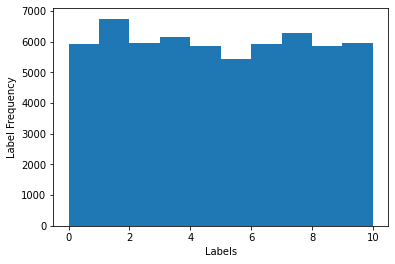

In [3]:
plt.figure()
plt.hist(Y_dev, bins = range(11))
plt.xlabel("Labels")
plt.ylabel("Label Frequency")
plt.show()

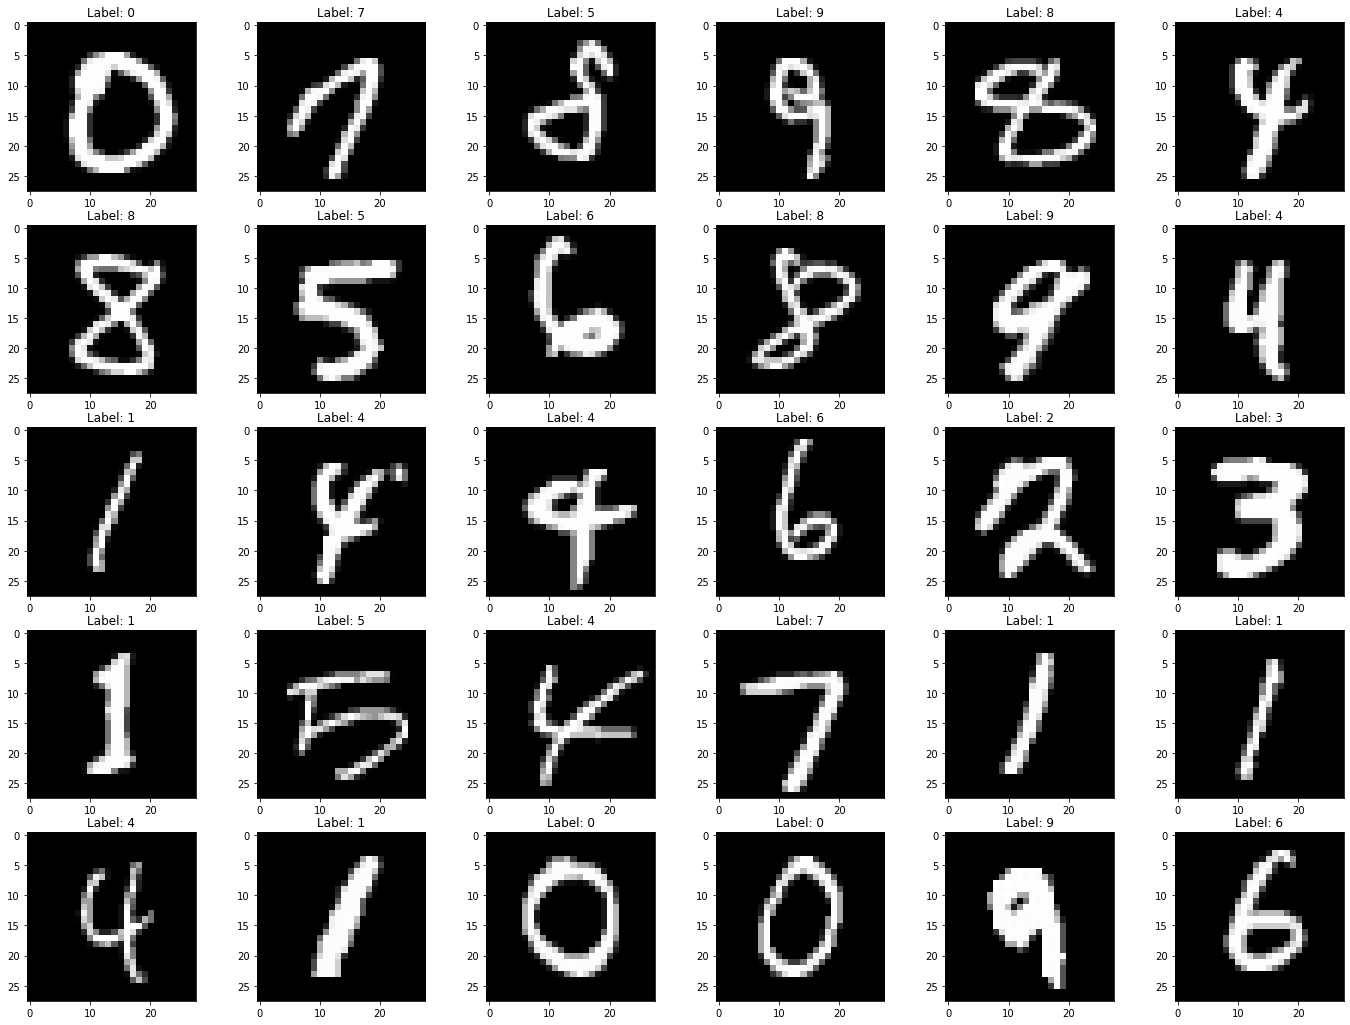

In [4]:
# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(X_dev.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_dev[jj], cmap = "gray")
    plt.title("Label: %d" %Y_dev[jj])
plt.show()

In [5]:
#The number of classes across samples looks balanced
# Let's shuffle the samples and split them
indexes = np.arange(X_dev.shape[0], dtype = int)
np.random.shuffle(indexes)
X_dev = X_dev[indexes]
Y_dev = Y_dev[indexes]

nsplit = int(0.75*X_dev.shape[0]) # Train/validation split

# Train and validation split
X_train = X_dev[:nsplit]
Y_train = Y_dev[:nsplit]
X_val = X_dev[nsplit:]
Y_val = Y_dev[nsplit:]



print("\nTrain set")
print("Images: ",X_train.shape)
print("Labels shape: ",Y_train.shape)
print("\nValidation set")
print("Images: ",X_val.shape)
print("Labels shape: ",Y_val.shape)


Train set
Images:  (45000, 28, 28)
Labels shape:  (45000,)

Validation set
Images:  (15000, 28, 28)
Labels shape:  (15000,)


In [6]:
print(X_train.min(),X_train.max(),X_train.mean(),X_train.std())
print(X_val.min(),X_val.max(),X_val.mean(),X_val.std())

0 255 33.331652069160995 78.57870649565149
0 255 33.278729591836736 78.53381746091745


## 2. Data Scaling 

In [7]:
norm_type = 0 # 0 -> min-max; 1-> standardization

if norm_type == 0:
    X_train = X_train/255
    X_val = X_val/255
    X_test = X_test/255
elif norm_type == 1:
    train_mean, train_std = X_train.mean(),X_train.std() 
    X_train = (X_train - train_mean)/train_std
    X_val = (X_val - train_mean)/train_std
    X_test = (X_test - train_mean)/train_std
else:
    pass

## 3. Define your callbacks (save your model, patience, etc.)

- [Keras callbacks](https://keras.io/api/callbacks/)

In [8]:
model_name = "autoencoder_mnist_cnn.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 4. Define your model, cost function, optimizer, learning rate

In [9]:
# Fully Connected Auto-encoder
def auto_encoder_fc(ishape = (28,28),ndim = 2, lr = 1e-4):
    input_img = tf.keras.layers.Input(shape = ishape)
    input_flat = tf.keras.layers.Flatten()(input_img)
    d1 = tf.keras.layers.Dense(500,activation = 'relu')(input_flat)
    d2 = tf.keras.layers.Dense(250,activation = 'relu')(d1)
    d3 = tf.keras.layers.Dense(ndim,activation = 'relu')(d2)
    encoder = tf.keras.models.Model(inputs = input_img, outputs = d3)
    input_decoder = tf.keras.layers.Input(shape = (ndim))
    d4 = tf.keras.layers.Dense(250,activation = 'relu')(input_decoder)
    d5 = tf.keras.layers.Dense(500,activation = 'relu')(d4)
    d6 = tf.keras.layers.Dense(ishape[0]*ishape[1],activation = 'linear')(d5)
    out = tf.keras.layers.Reshape(ishape)(d6)
    decoder = tf.keras.models.Model(inputs = input_decoder, outputs = out)
    autoencoder = tf.keras.models.Model(inputs = input_img, outputs = decoder(encoder(input_img)))
    autoencoder.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr), loss = "mse")
    return encoder,decoder,autoencoder

# CNN
def auto_encoder_cnn(ishape = (28,28,1),ndim = 10, lr = 1e-4):
    input_img = tf.keras.layers.Input(shape = ishape)
    c1 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', strides = (2,2), padding = 'same')(input_img)
    c2 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', strides = (2,2), padding = 'same')(c1)
    c3 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', strides = (2,2), padding = 'same')(c2)
    flat = tf.keras.layers.Flatten()(c3)
    d1 = tf.keras.layers.Dense(ndim)(flat)
    encoder = tf.keras.models.Model(inputs = input_img, outputs = d1)
    input_decoder = tf.keras.layers.Input(shape = (ndim))
    d2 = tf.keras.layers.Dense(4*4*128)(input_decoder)
    reshaped_img = tf.keras.layers.Reshape((4,4,128))(d2)
    up1 = tf.keras.layers.UpSampling2D((2,2))(reshaped_img)
    c4 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same')(up1)
    up2 = tf.keras.layers.UpSampling2D((2,2))(c4)
    c5 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu')(up2)
    up3 = tf.keras.layers.UpSampling2D((2,2))(c5)
    c6 = tf.keras.layers.Conv2D(1, (3,3), activation = 'relu', padding = 'same')(up3)
    decoder = tf.keras.models.Model(inputs = input_decoder , outputs = c6)
    autoencoder = tf.keras.models.Model(inputs = input_img, outputs = decoder(encoder(input_img)))
    autoencoder.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr), loss = "mse")
    return encoder,decoder,autoencoder

In [10]:
encoder,decoder,autoencoder = auto_encoder_cnn(ndim = 10)
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 113,162
Trainable params: 113,162
Non-trainable params: 0
_______________________________________________________

## 6. Train your model

In [11]:
autoencoder.fit(X_train,X_train,batch_size = 64, epochs = 10, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(X_val,X_val))

Epoch 1/10
704/704 [==============================] - 4s 6ms/step - loss: 0.0465 - val_loss: 0.0285 - lr: 5.0000e-05
Epoch 2/10
704/704 [==============================] - 4s 6ms/step - loss: 0.0258 - val_loss: 0.0235 - lr: 5.0000e-05
Epoch 3/10
704/704 [==============================] - 4s 6ms/step - loss: 0.0228 - val_loss: 0.0217 - lr: 5.0000e-05
Epoch 4/10
704/704 [==============================] - 7s 11ms/step - loss: 0.0212 - val_loss: 0.0205 - lr: 5.0000e-05
Epoch 5/10
704/704 [==============================] - 4s 6ms/step - loss: 0.0202 - val_loss: 0.0197 - lr: 5.0000e-05
Epoch 6/10
704/704 [==============================] - 3s 4ms/step - loss: 0.0195 - val_loss: 0.0190 - lr: 5.0000e-05
Epoch 7/10
704/704 [==============================] - 3s 4ms/step - loss: 0.0189 - val_loss: 0.0185 - lr: 5.0000e-05
Epoch 8/10
704/704 [==============================] - 4s 6ms/step - loss: 0.0185 - val_loss: 0.0181 - lr: 5.0000e-05
Epoch 9/10
704/704 [==============================] - 4s 6ms/st

In [12]:
autoencoder.load_weights(model_name)
metrics = autoencoder.evaluate(X_test,X_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0174


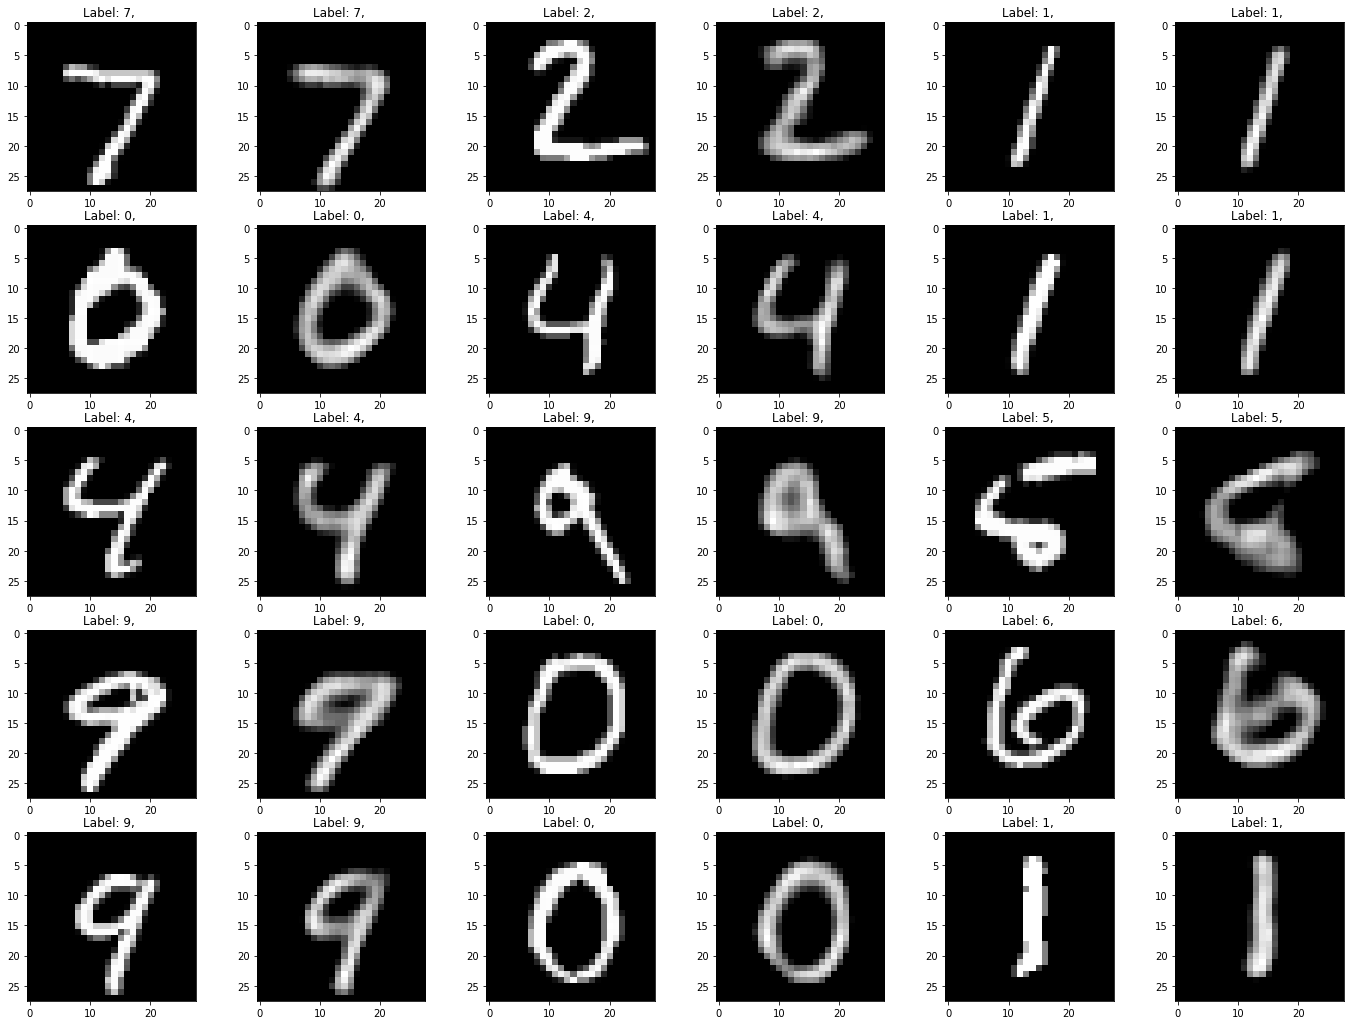

In [14]:
Xpred = autoencoder.predict(X_test)[:,:,:,0]



plt.figure(figsize = (24,18))
for (ii) in range(15):
    plt.subplot(5,6,ii*2+1)
    plt.imshow(X_test[ii], cmap = "gray")
    plt.title("Label: %d, " %(Y_test[ii]))
    plt.subplot(5,6,ii*2 + 2)
    plt.imshow(Xpred[ii], cmap = "gray")
    
    plt.title("Label: %d, " %(Y_test[ii]))
plt.show()

In [ ]:
# Only works for ndim = 2
Xencoded = encoder.predict(X_test)
plt.figure()
for ii in range(10):
    plt.plot(Xencoded[Y_test == ii,0],Xencoded[Y_test == ii,1],'x', label = "Digit %s" %(str(ii)))
plt.legend()
plt.show()

## (Bonus) Denoising auto-encoder

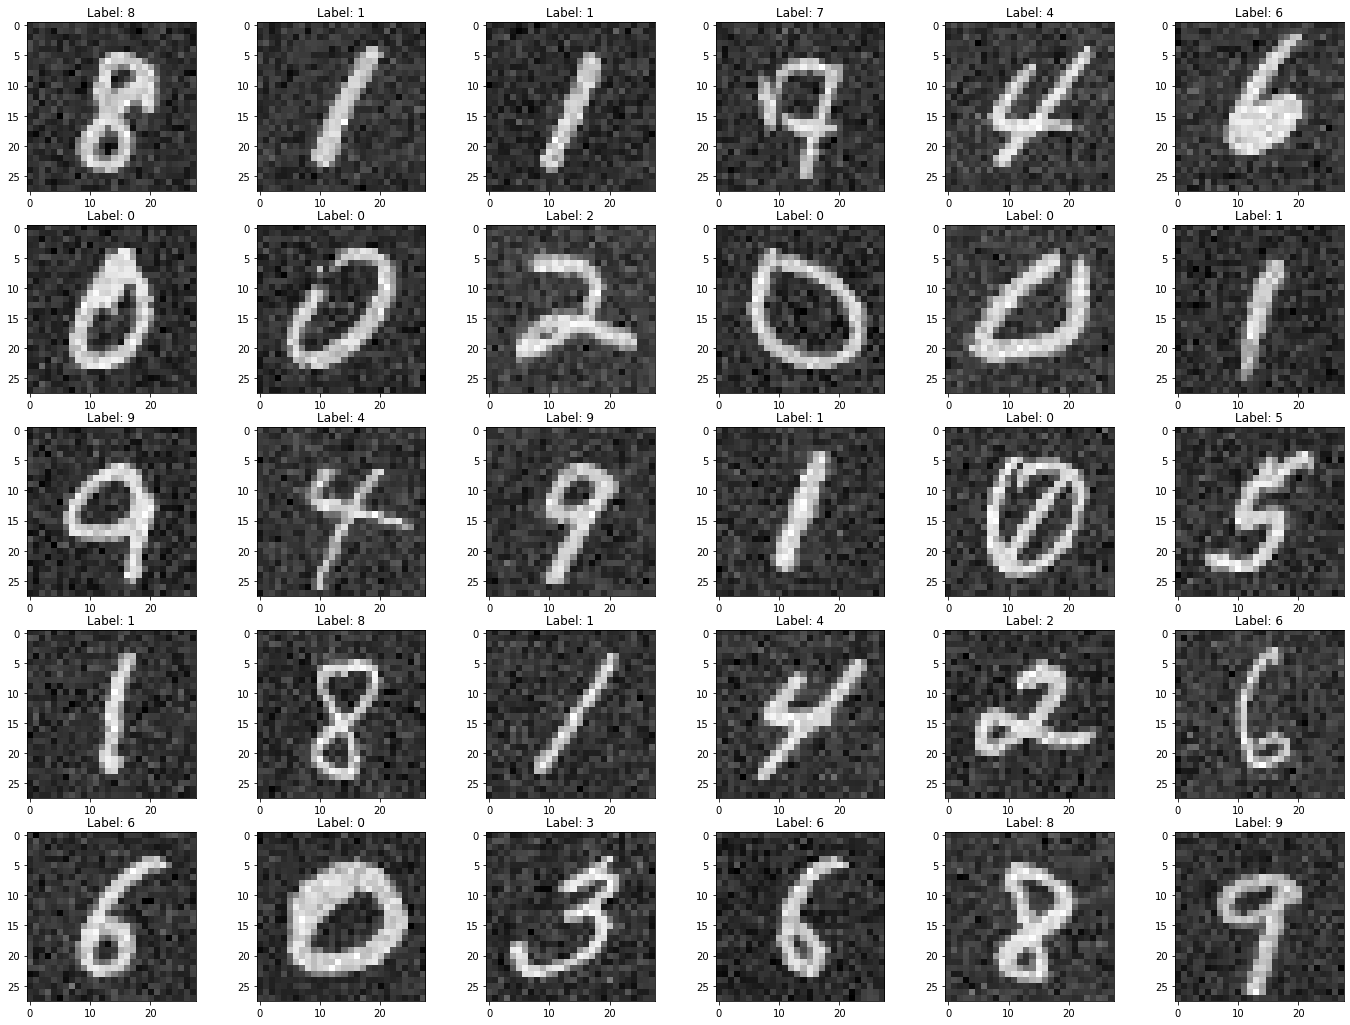

In [15]:
# Adding noise
mu = 0
sigma = 0.1
X_train_noisy = X_train + np.random.normal(mu,sigma,X_train.shape)
X_val_noisy = X_val + np.random.normal(mu,sigma,X_val.shape)
X_test_noisy = X_test + np.random.normal(mu,sigma,X_test.shape)


# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(X_train_noisy.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_train_noisy[jj], cmap = "gray")
    plt.title("Label: %d" %Y_dev[jj])
plt.show()

In [16]:
model_name = "autoencoder_mnist_cnn_denoiser.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [17]:
encoder,decoder,autoencoder = auto_encoder_cnn(ndim = 10)
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                20490     
Total params: 113,162
Trainable params: 113,162
Non-trainable params: 0
_____________________________________________________

In [18]:
autoencoder.fit(X_train_noisy,X_train,batch_size = 64, epochs = 10, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(X_val,X_val))

Epoch 1/10
704/704 [==============================] - 5s 8ms/step - loss: 0.0485 - val_loss: 0.0294 - lr: 5.0000e-05
Epoch 2/10
704/704 [==============================] - 6s 9ms/step - loss: 0.0266 - val_loss: 0.0246 - lr: 5.0000e-05
Epoch 3/10
704/704 [==============================] - 6s 9ms/step - loss: 0.0235 - val_loss: 0.0227 - lr: 5.0000e-05
Epoch 4/10
704/704 [==============================] - 5s 8ms/step - loss: 0.0218 - val_loss: 0.0211 - lr: 5.0000e-05
Epoch 5/10
704/704 [==============================] - 6s 9ms/step - loss: 0.0206 - val_loss: 0.0204 - lr: 5.0000e-05
Epoch 6/10
704/704 [==============================] - 5s 8ms/step - loss: 0.0198 - val_loss: 0.0195 - lr: 5.0000e-05
Epoch 7/10
704/704 [==============================] - 4s 6ms/step - loss: 0.0192 - val_loss: 0.0191 - lr: 5.0000e-05
Epoch 8/10
704/704 [==============================] - 4s 6ms/step - loss: 0.0187 - val_loss: 0.0184 - lr: 5.0000e-05
Epoch 9/10
704/704 [==============================] - 6s 9ms/ste

In [19]:
autoencoder.load_weights(model_name)
metrics = autoencoder.evaluate(X_test_noisy,X_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0174


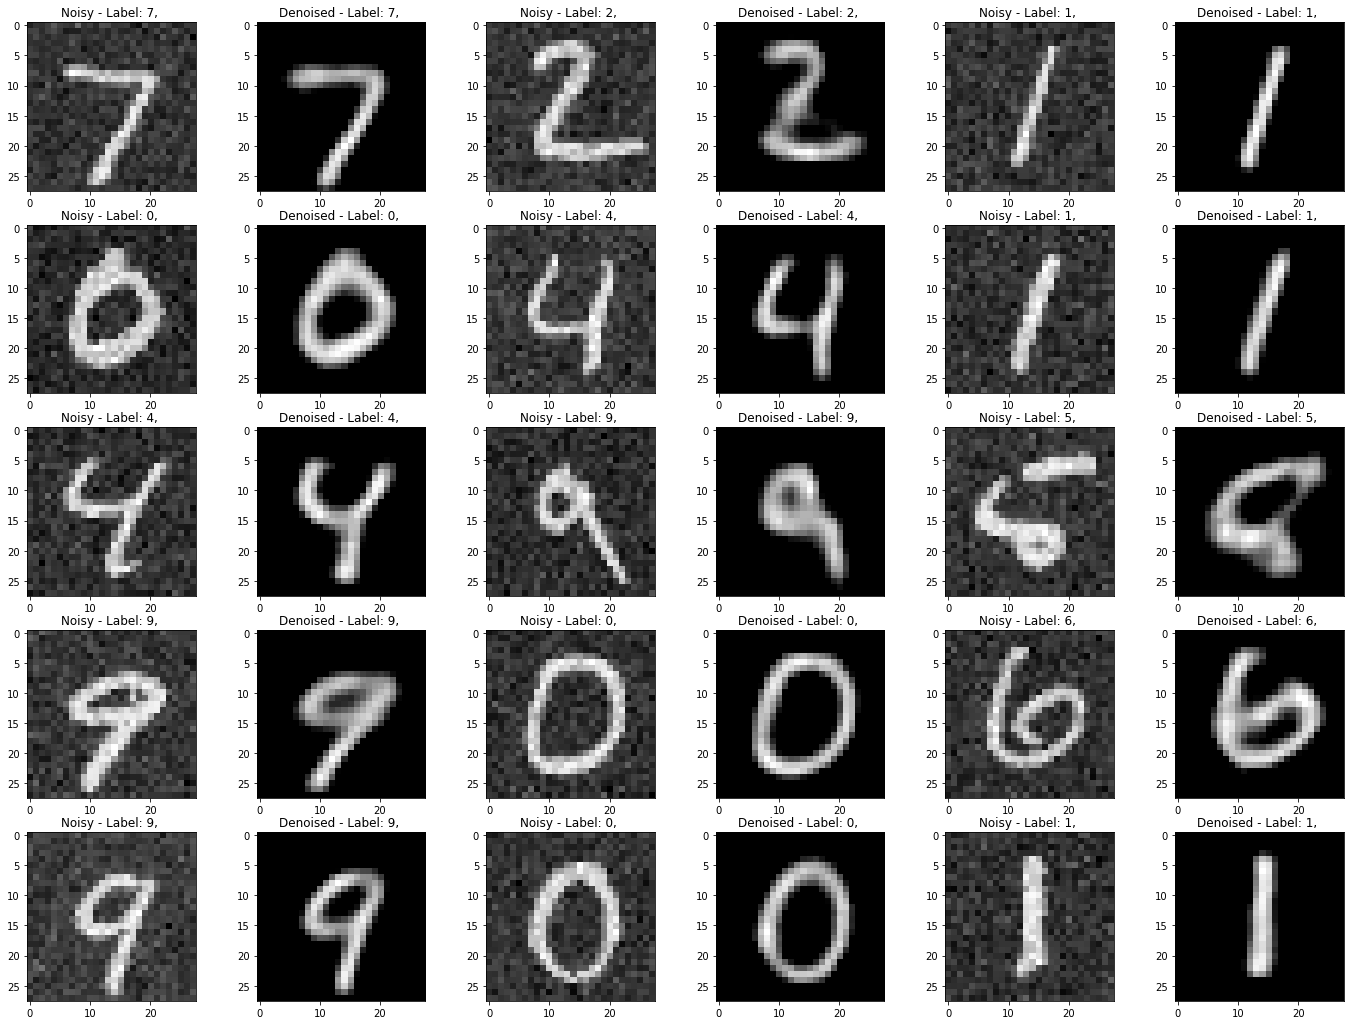

In [21]:
Xpred = autoencoder.predict(X_test_noisy)[:,:,:,0]



plt.figure(figsize = (24,18))
for (ii) in range(15):
    plt.subplot(5,6,ii*2+1)
    plt.imshow(X_test_noisy[ii], cmap = "gray")
    plt.title("Noisy - Label: %d, " %(Y_test[ii]))
    plt.subplot(5,6,ii*2 + 2)
    plt.imshow(Xpred[ii], cmap = "gray")
    
    plt.title("Denoised - Label: %d, " %(Y_test[ii]))
plt.show()